In [2]:
%matplotlib inline
# plot the molecule in 3D in an interactive window
# %matplotlib widget
%config InlineBackend.figure_format = 'retina'

In [3]:
# get current working directory
import os, sys
pwd = os.getcwd()
# append ../src/ to the sys path to access the coarsegrainer package
sys.path.append(pwd + '/../src/')

In [4]:
import time
# import collections

import numpy as np
import pandas as pd

import torch
# import torch.nn.functional as F

import matplotlib.pyplot as plt

### import the coarse-graining module
import coarsegrainer as cg
from coarsegrainer.minimizer import EnergyMinimizerPytorch, CGMinimizerPytorch, GNNMinimizerPytorch
from coarsegrainer.energy import Energy, LJ_potential, quadratic_potential
from coarsegrainer.plotting import plot_line_3D, plot_graph

from experimentlogger import ExperimentLogger

V = lambda x: x.detach().cpu().numpy()

## Quadratic Bonds + LJ loop
Define an energy function which uses a quadratic potential for bonds and LJ for forming a loop. 
It consists of:
1. a strong backbone line graph LJ, where every node is attracted to the next
2. a weaker loop LJ, where every l-th pair of nodes are attracted 

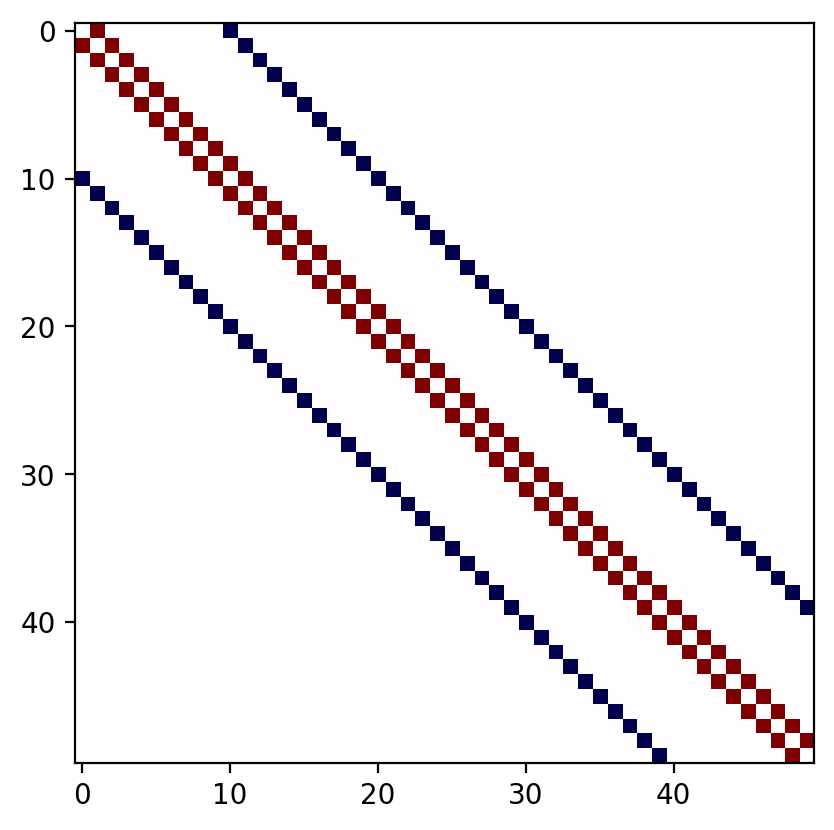

In [5]:
num_nodes, dims = 400, 3

n,d = num_nodes, dims
loop = 10
a = 1e-1

# init_sigma = 3.0 # initial standard deviation of the coordinates
# an initial std of 
init_sigma = n**(1/3)/2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

A = cg.utils.line_graph_A(n, k=1).to(device)
vdw = cg.utils.line_graph_A(n, k=loop).to(device)

A_loop = A+a*vdw

x = init_sigma*torch.randn(n, d).to(device) 

plt.imshow(V(A-vdw)[:50,:50], cmap='seismic', vmin=-1, vmax=1)

In [6]:
energy_params = dict(radius = 1, thres_A = 1e-4, lj_pow = 6, repel_pow = 1, repel_mag = 2.5e-3, 
                device = 'cuda')

energy_lj = Energy([A_loop], [LJ_potential],log_name='Energy_LJ_2scale', **energy_params)
energy_bond_lj = Energy([A, .1*vdw], [quadratic_potential, LJ_potential],log_name='Energy_Bond_LJ', **energy_params)

In [7]:
energy_bond_lj(x).item(), energy_lj(x).item()

(55.83159255981445, 0.022225812077522278)

## Training

In [8]:
# early stopping criteria
PATIENCE = 20
MIN_DELTA = 1e-6

# learning rate
LR = 2e-2

In [9]:
# exp_logger = ExperimentLogger(previous_results_csv='../results/CG_experiment_2024-02-09-01.csv')
exp_logger = ExperimentLogger(save_prefix='../results/CG_Bond_LJ_experiment') 
test_logger = ExperimentLogger(save_prefix='../results/test')

In [11]:
df = exp_logger.df

AttributeError: 'ExperimentLogger' object has no attribute 'df'

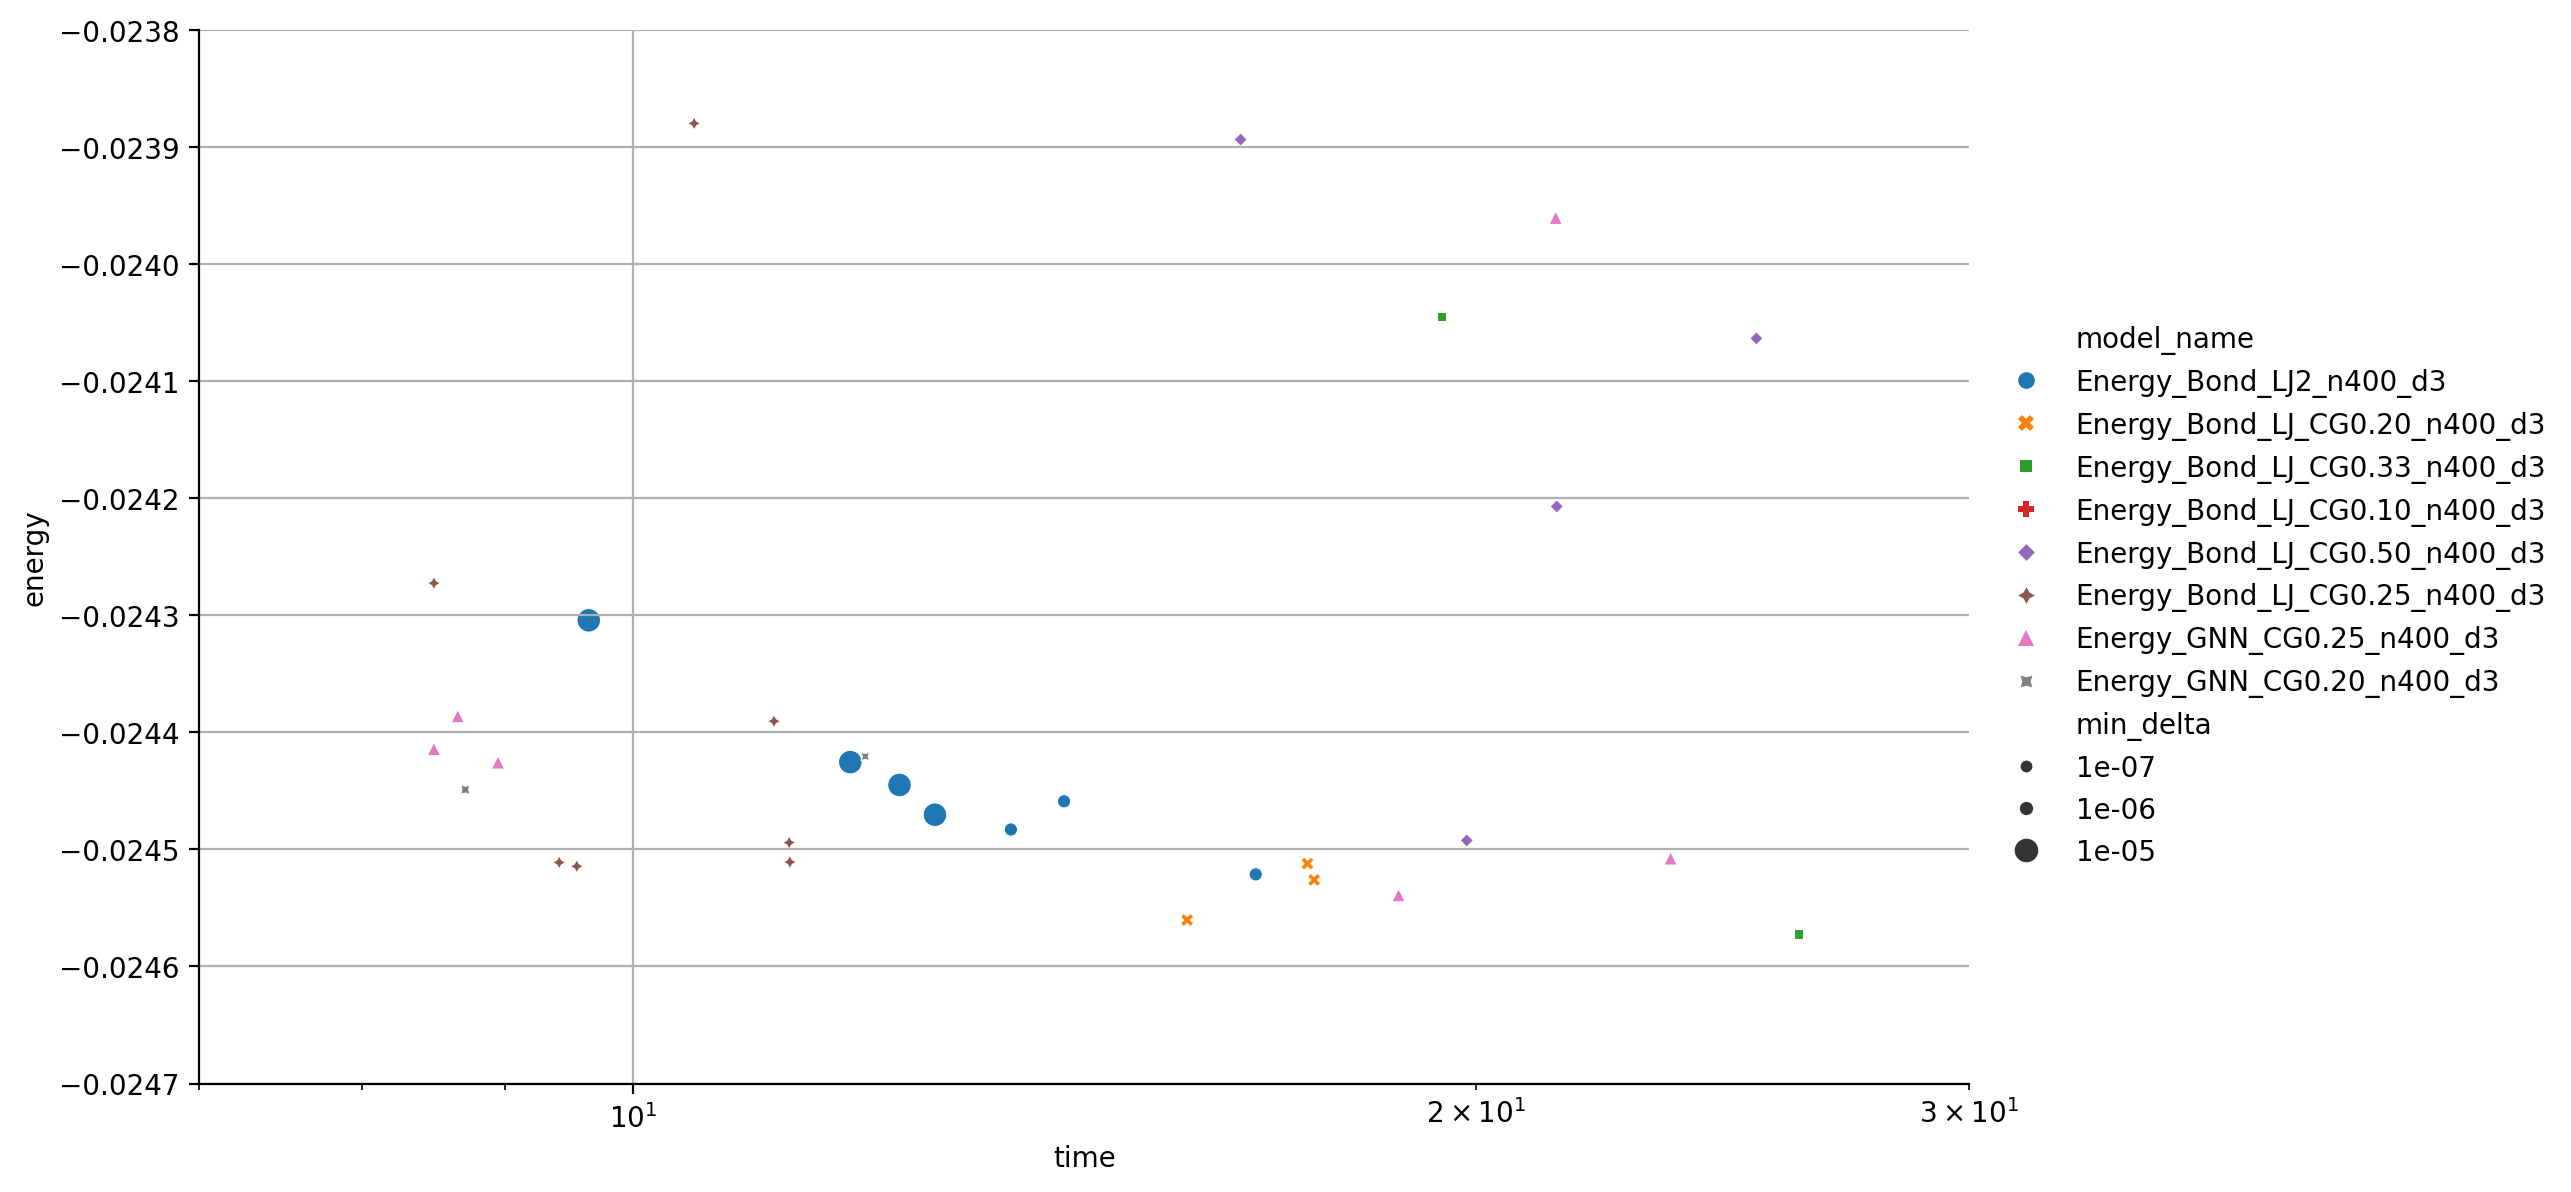

In [227]:
# plot the filtered dataframe using sns directly on df
sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='min_delta', height=6, aspect=1.7)

plt.ylim(-.0247, -.0238)
plt.xlim(7,30)
plt.xscale('log')
plt.grid()

## LJ only

In [10]:
# example of using the EnergyMinimizerPytorch class
# define the initial position
# initial_pos = x = init_sigma*1*torch.randn(n, d).to(device) /2

initial_pos = x = init_sigma*torch.randn(n, d).to(device) /3
# instantiate the EnergyMinimizerPytorch class
# energy_minimizer = EnergyMinimizerPytorch(energy_lj, initial_pos, optimizer_type='Adam', lr=1e-2, clamp_grads=.1, log_step=20, log_pos_step=0, 
#                             log_dir='../results/logs', log_name='LJ_loop', patience=PATIENCE*1, min_delta=MIN_DELTA*1e-0)
energy_minimizer = EnergyMinimizerPytorch(energy_lj, initial_pos, optimizer_type='Adam', lr=1e-3, clamp_grads=.01, log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name='LJ_loop', patience=PATIENCE*1, min_delta=MIN_DELTA*1e-0)

Using Adam optimizer
Log name: LJ_loop
Logging to: ../results/logs/LJ_loop_n400_d3


In [11]:
r = 1.5e-1
# v = plot_graph_3D(V(energy_minimizer.get_x()), A,  node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='blue', edge_color='blue')
v = plot_line_3D(V(energy_minimizer.get_x()), A, r = r, eps=1e-4, colormap='jet')
# Capture the current view as a PNG image
# v.png()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [12]:
exp_logger.run_experiment(energy_minimizer, epochs=10, steps=5000, x0_std=initial_pos.std().item())

Running experiment LJ_loop_n400_d3
250 -0.0129, 3.97
500 -0.0163, 7.77
Early stopping at step 380
520 -0.0162, 8.06


Text(0.5, 1.0, 'Energy vs time (min E: -0.0163, t=8.06 s)')

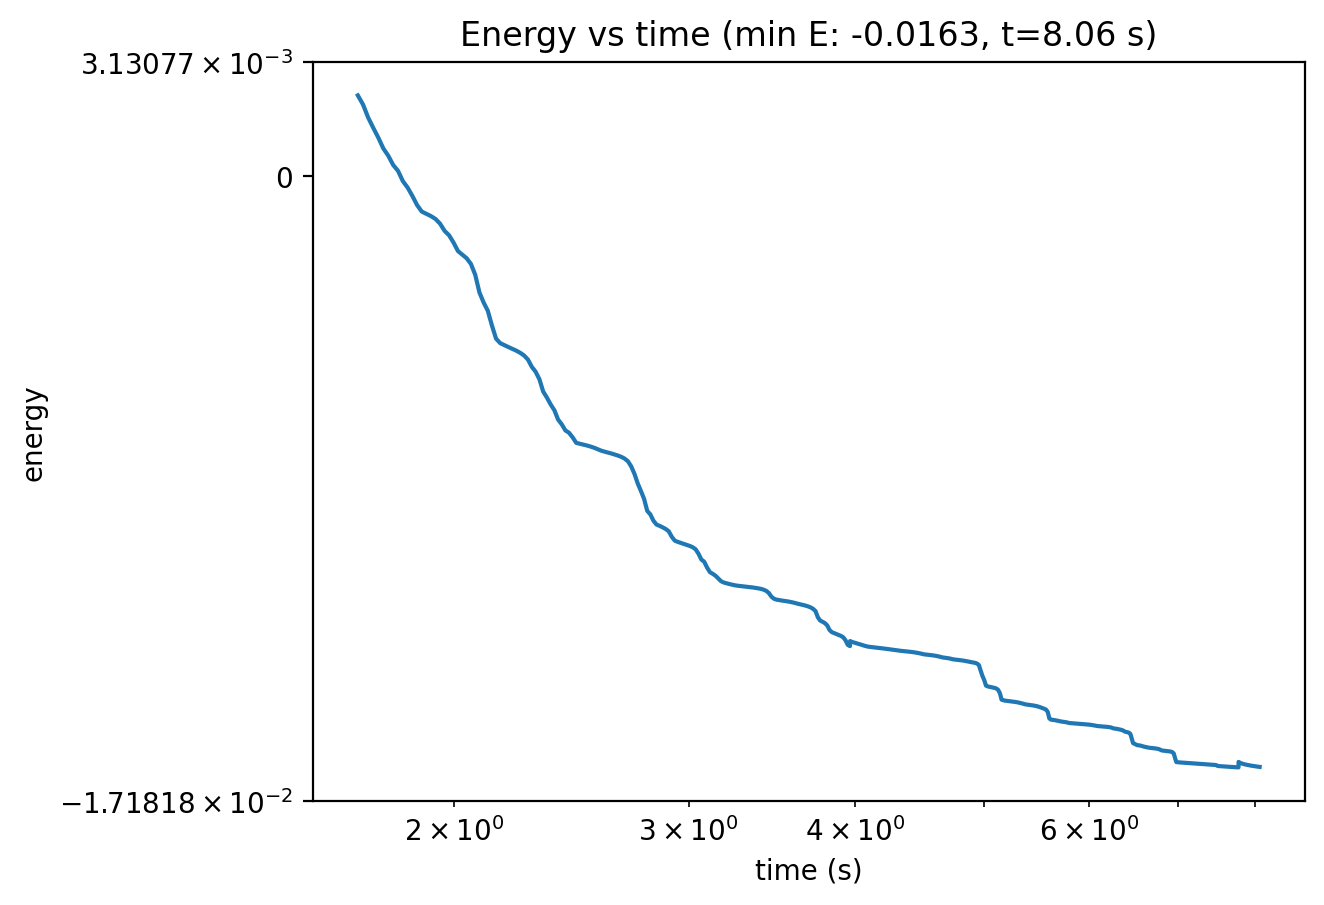

In [13]:
energy_minimizer.plot_history(start=100)
h = energy_minimizer.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')


In [14]:
exp_logger.df

,energy_function,model_name,energy,time,lr,clamp_grads,patience,min_delta,x0_std
0,Energy_LJ_2scale,LJ_loop_n400_d3,-0.016245,8.059274,0.001,0.01,20,0.000001,1.204357


In [15]:
energy_minimizer.get_x().std(), init_sigma

(tensor(1.8430, device='cuda:0', grad_fn=<StdBackward0>), 3.6840314986403864)

In [16]:
r = 2.5e-1
# v = plot_graph_3D(V(energy_minimizer.get_x()), A,  node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='blue', edge_color='blue')
v = plot_line_3D(V(energy_minimizer.get_x()), A, r = r, eps=1e-4, colormap='jet')
# Capture the current view as a PNG image
# v.png()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### CG Using multiple samples

In [51]:
init_sigma

3.6840314986403864

In [34]:
t0 = time.time()
# x_samples = init_sigma/2*torch.randn(4*n, n, d, device =device)
# note: large init_sigma resulted in diverging hessian
# x_samples = init_sigma*1*torch.randn(4*n, n, d, device =device)
k = 40
# produce k samples with different std for x
x_samples = init_sigma*torch.randn(k, n, d, device =device)*torch.linspace(1e-2, 2e-1, k)[:, None, None].to(device)
# x_samples = init_sigma*torch.randn(k, n, d, device =device)*torch.linspace(1e-1, 2e-0, k)[:, None, None].to(device)
cg_bond_lj = cg.CG.CoarseGrainer(energy_lj, num_cg_modes=120)
cg_bond_lj.get_cg_modes(x_samples)
cg_time = time.time() - t0
cg_time

force constant matrix computed in 0.28 seconds
spectrum of the Laplacian computed in 0.01 seconds


0.2922096252441406

In [35]:
init_sigma/16, 1/(2*d)

(0.23025196866502415, 0.16666666666666666)

In [36]:
A.shape, x.shape

(torch.Size([400, 400]), torch.Size([400, 3]))

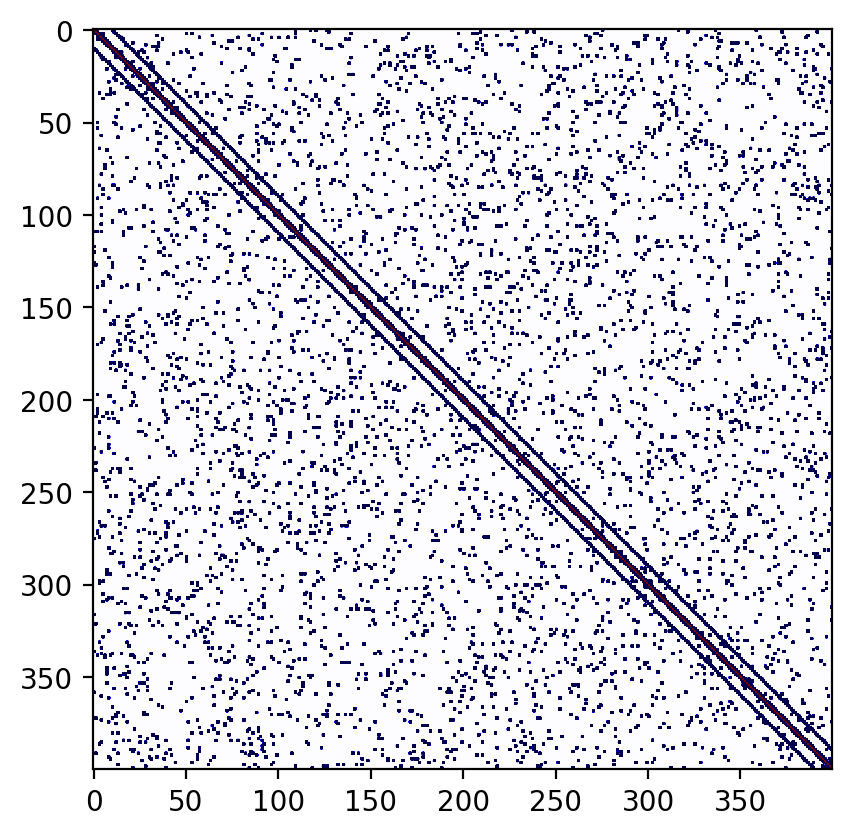

In [37]:
b = 1e-3
plt.imshow(np.arcsinh(1e3*V(cg_bond_lj.L)), cmap='seismic', vmin=-b, vmax=b)


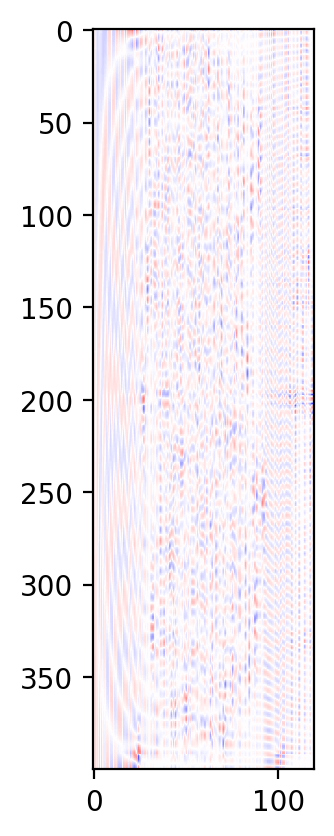

In [38]:
c = V(cg_bond_lj.cg_modes)
plt.imshow(c, cmap='seismic', vmin=-1, vmax=1) 

In [39]:
# cg_minimizer.start_fine_graining()
# cg_minimizer.early_stopping_triggered = False
# h = cg_minimizer.train(20000)

### Multi-stage CG
gradually increase the number cg modes used

In [20]:
cg_min_params = dict(optimizer_type='Adam', lr=1e-3, lr_cg=1e-1,
            clamp_grads=.01, log_step=20, log_pos_step=0, 
            log_dir='../results/logs', log_name='CG_LJ_loop', 
            patience=PATIENCE, min_delta=MIN_DELTA,
            cg_patience=PATIENCE, cg_min_delta=MIN_DELTA*10)

In [21]:
num_cg_modes = n//4
initial_pos = x = init_sigma*torch.randn(n, d).to(device) /3
# instantiate the CGMinimizerPytorch class
cg_minimizer = CGMinimizerPytorch(energy_lj, initial_pos, cg_bond_lj.cg_modes[:,:num_cg_modes], **cg_min_params)

Using Adam optimizer
Log name: CG_LJ_loop
Logging to: ../results/logs/CG_LJ_loop_n400_d3
Using Adam optimizer


In [22]:
exp_logger.run_experiment(cg_minimizer, epochs=10, steps=5000, x0_std=initial_pos.std().item())

Running experiment CG_LJ_loop_n400_d3
250 0.231, 4.10
500 0.226, 7.94
Early stopping at step 1720
Starting fine-graining
837 0.196, 12.93
1087 0.193, 16.59
1337 0.193, 20.24
Early stopping at step 320
1354 0.193, 20.47


In [23]:
cg_minimizer.cg_steps

587

Text(0.5, 1.0, 'Energy vs time (min E: 0.193, t=20.47 s)')

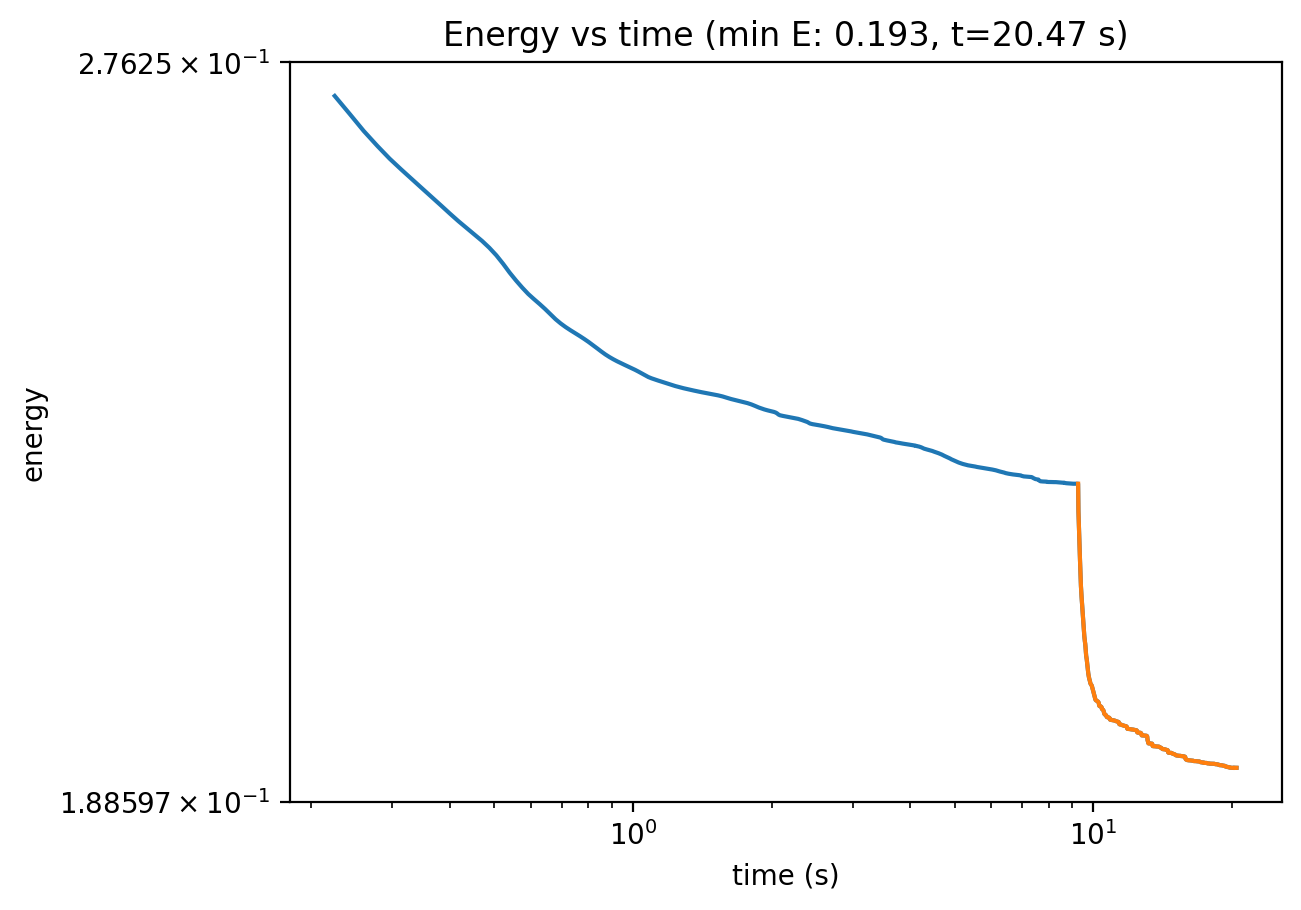

In [27]:
cg_minimizer.plot_history(start=10)
cg_minimizer.plot_history(start=cg_minimizer.cg_steps)
h = cg_minimizer.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')


In [28]:
cg_minimizer.fine_grained

True

In [29]:
r = 5e-1
# v = plot_graph_3D(V(cg_minimizer.get_x()), A, node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='red', edge_color='red')
v = plot_line_3D(V(cg_minimizer.get_x()), A, r = 5e-1, eps=1e-4, colormap='jet')

# Capture the current view as a PNG image
# v.png()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [30]:
h = cg_minimizer.train_one_stage(20000)

Early stopping at step 0


{'time': [0.0384974479675293,
  0.020319223403930664,
  0.018326282501220703,
  0.01755380630493164,
  0.01748180389404297,
  0.017602920532226562,
  0.020549297332763672,
  0.01880502700805664,
  0.019991159439086914,
  0.018091440200805664,
  0.017705440521240234,
  0.017510175704956055,
  0.017612934112548828,
  0.018502235412597656,
  0.017473459243774414,
  0.017475366592407227,
  0.017421483993530273,
  0.01742100715637207,
  0.01735663414001465,
  0.01729583740234375,
  0.017351627349853516,
  0.01734185218811035,
  0.017358779907226562,
  0.017400741577148438,
  0.01758599281311035,
  0.017403602600097656,
  0.017495393753051758,
  0.017384767532348633,
  0.017403125762939453,
  0.01751708984375,
  0.017374038696289062,
  0.01740121841430664,
  0.017374038696289062,
  0.017429828643798828,
  0.0174100399017334,
  0.017516136169433594,
  0.017372608184814453,
  0.01744699478149414,
  0.017401933670043945,
  0.01741957664489746,
  0.017400264739990234,
  0.017369508743286133,
  0

In [ ]:
cg_minimizer.history.keys()

dict_keys(['time', 'energy', 'x'])

In [31]:
t0 = time.time()
# x_samples = init_sigma/2*torch.randn(4*n, n, d, device =device)
# note: large init_sigma resulted in diverging hessian
# x_samples = init_sigma*1*torch.randn(4*n, n, d, device =device)
k = 10
# produce k samples with different std for x

x0 = cg_minimizer.get_x().detach().clone()
s = x0.std().item()

x_samples = s/10*torch.randn(k, n, d, device = device)*torch.linspace(2e-1, 1e0, k)[:, None, None].to(device)
x_samples = x_samples + x0

cg_bond_lj = cg.CG.CoarseGrainer(energy_lj, num_cg_modes=120)
cg_bond_lj.get_cg_modes(x_samples)
cg_time = time.time() - t0
cg_time

force constant matrix computed in 0.07 seconds
spectrum of the Laplacian computed in 0.01 seconds


0.08814072608947754

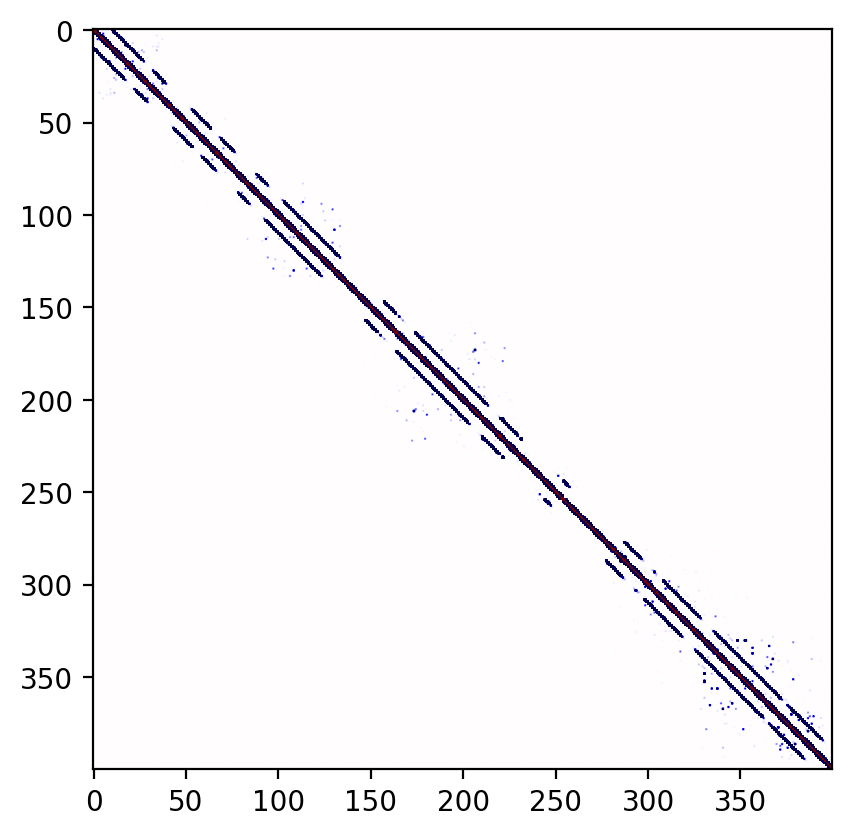

In [32]:
b = 1e-3
plt.imshow(np.arcsinh(1e3*V(cg_bond_lj.L)), cmap='seismic', vmin=-b, vmax=b)


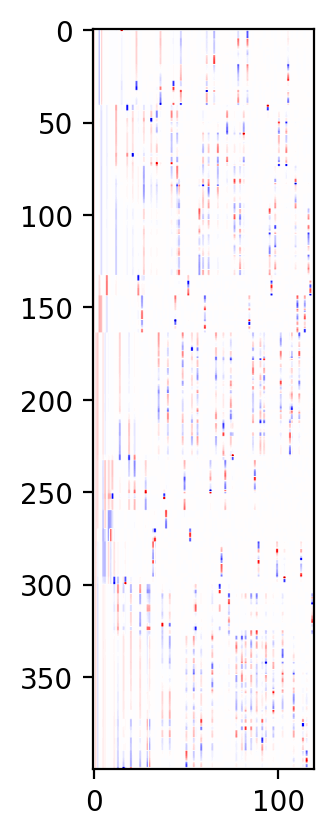

In [33]:
c = V(cg_bond_lj.cg_modes)
plt.imshow(c, cmap='seismic', vmin=-1, vmax=1) 

In [ ]:
h = cg_bond_lj.hessian(cg_minimizer.get_x())

NameError: name 'cg_minimizer' is not defined

In [ ]:
plt.imshow(np.arcsinh(1e3*V(h.norm(dim=(1,3))))[:100,:100], cmap='seismic', vmin=-1, vmax=1)


NameError: name 'h' is not defined